In [69]:
from datasets import load_dataset
import json
import requests
from bs4 import BeautifulSoup, Comment
from bs4 import Tag
from collections import deque
from sklearn.metrics.pairwise import cosine_similarity
from groq import Groq
import os
import time

similarity = cosine_similarity

In [2]:
ds = load_dataset(
    "google-research-datasets/natural_questions", "dev", split="validation"
)

In [166]:
for i in range(10):
    print(ds[i]["document"]["title"])
    print(ds[i]["document"]["url"])

Wave–particle duality
https://en.wikipedia.org//w/index.php?title=Wave%E2%80%93particle_duality&amp;oldid=837021290
Current members of the United States Senate
https://en.wikipedia.org//w/index.php?title=Current_members_of_the_United_States_Senate&amp;oldid=822209735
Deposition (phase transition)
https://en.wikipedia.org//w/index.php?title=Deposition_(phase_transition)&amp;oldid=832599453
Longest word in English
https://en.wikipedia.org//w/index.php?title=Longest_word_in_English&amp;oldid=818685520
NBA All-Star Game Most Valuable Player Award
https://en.wikipedia.org//w/index.php?title=NBA_All-Star_Game_Most_Valuable_Player_Award&amp;oldid=831162386
Water distribution on Earth
https://en.wikipedia.org//w/index.php?title=Water_distribution_on_Earth&amp;oldid=837043390
Who Wants to Be a Millionaire? New Zealand
https://en.wikipedia.org//w/index.php?title=Who_Wants_to_Be_a_Millionaire%3F_New_Zealand&amp;oldid=742185609
Brock
https://en.wikipedia.org//w/index.php?title=Brock&amp;oldid=8163

In [567]:
i = 2

sample1 = ds[i]["document"]["html"]
ques1 = ds[i]["question"]["text"]
token_list1 = ds[i]["document"]["tokens"]
short_answer = ds[i]["annotations"]
long_answer = ds[i]["long_answer_candidates"]

In [369]:
sample1

'<!DOCTYPE html>\n<HTML class="client-js ve-not-available" lang="en" dir="ltr"><HEAD>\n\n<TITLE>Current members of the United States Senate - Wikipedia</TITLE>\n\n\n<LINK rel="stylesheet" href="/w/load.php?debug=false&amp;lang=en&amp;modules=ext.cite.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cmediawiki.legacy.commonPrint%2Cshared%7Cmediawiki.sectionAnchor%7Cmediawiki.skinning.interface%7Cskins.vector.styles%7Cwikibase.client.init&amp;only=styles&amp;skin=vector" />\n\n<STYLE>\n.referencetooltip{position:absolute;list-style:none;list-style-image:none;opacity:0;font-size:10px;margin:0;z-index:5;padding:0}.referencetooltip li{border:#080086 2px solid;max-width:260px;padding:10px 8px 13px 8px;margin:0px;background-color:#F7F7F7;-webkit-box-shadow:2px 4px 2px rgba(0,0,0,0.3);-moz-box-shadow:2px 4px 2px rgba(0,0,0,0.3);box-shadow:2px 4px 2px rgba(0,0,0,0.3)}.referencetooltip li+li{margin-left:7px;margin-top:-2px;border:0;padding:0;

In [ ]:
for candidate in zip(
    long_answer["start_token"],
    long_answer["end_token"],
    long_answer["start_byte"],
    long_answer["end_byte"],
    long_answer["top_level"],
):
    start_byte, end_byte = candidate[2], candidate[3]
    start_token, end_token = candidate[0], candidate[1]
    if candidate[4] is True:
        print(start_byte, end_byte, start_token, end_token)

        print(sample1[start_byte:end_byte])
        print(token_list1["token"][start_token], token_list1["token"][end_token])

In [210]:
sample2 = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>More Complex Example</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            border: 1px solid #ccc;
        }
        h1, h2 {
            color: #333;
        }
        p {
            margin-bottom: 15px;
        }
        ul {
            list-style-type: disc;
            padding-left: 20px;
        }
        a {
            color: blue;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
        #important {
            font-weight: bold;
            color: red;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Welcome to My Website</h1>
        <p>This is a more detailed example with additional content and styling. We're exploring various HTML elements and CSS properties.</p>

        <h2>Section 1: Introduction</h2>
        <p>This section provides an overview of the topic. We'll discuss key concepts and provide context.</p>
        <ul>
            <li>Point 1: A key feature.</li>
            <li>Point 2: Another important aspect.</li>
            <li>Point 3: A supporting detail.</li>
        </ul>

        <h2>Section 2: Further Details</h2>
        <p>Here, we delve deeper into the subject matter. You can find more information and examples below.</p>
        <p id="important">This is an important paragraph with special styling.</p>
        <a href="https://www.example.com">Visit Example Website</a>

        <div>
          <h3>A Sub Section</h3>
          <p>Some more text here</p>
          <img src="dummy_image.jpg" alt="Dummy Image" width="300">
        </div>
    </div>
</body>
</html>"""

In [468]:
class BlockNode:
    def __init__(self, tag, attributes=None, content=None):
        self.tag = tag
        self.path = []
        self.attributes = attributes or {}
        self.content = content.strip() if content else ""
        self.children = []
        self.block = ""
        self.is_leaf = False
        self.embedding = None

    def add_child(self, child):
        self.children.append(child)

    def to_dict(self):
        return {
            "tag": self.tag,
            "attributes": self.attributes,
            "content": self.content,
            "children": [child.to_dict() for child in self.children],
        }

In [469]:
def clean_html(html_content):
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Step 1: HTML Content Cleaning
    # Remove <script>, <style>, and comments
    for tag in soup(["script", "style"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    # Remove lengthy attributes (e.g., inline styles, large data attributes)
    def clean_attributes(tag):
        for attr in list(tag.attrs.keys()):
            if len(str(tag[attr])) > 50:  # Arbitrary threshold for "lengthy"
                del tag[attr]

    for tag in soup.find_all(True):  # All tags
        clean_attributes(tag)

    # Step 2: Lossless Structural Compression
    # Merge single-nested tags
    def merge_single_nested_tags(tag):
        while (
            len(tag.contents) == 1
            and isinstance(tag.contents[0], Tag)
            and tag.contents[0].name == tag.name
        ):
            child = tag.contents[0]
            tag.attrs.update(child.attrs)  # Merge attributes
            tag.contents = child.contents  # Replace contents
        for child in tag.find_all(recursive=False):
            merge_single_nested_tags(child)

    # Remove all \t and \n in the data
    for text in soup.find_all(string=True):
        text.replace_with(text.replace("\n", "").replace("\t", ""))
    for tag in soup.find_all(True):  # All tags
        merge_single_nested_tags(tag)

    # Remove empty tags
    for tag in soup.find_all():
        if not tag.contents or all(
            str(content).strip() == "" for content in tag.contents
        ):
            tag.decompose()

    return soup

In [470]:
def build_dom_tree(html_content):
    def build_tree(element):
        if not element.name:
            return None

        # Create a BlockNode for the current element
        node = BlockNode(
            tag=element.name,
            attributes=element.attrs,
            content=element.get_text(strip=True) if element.string else "",
        )
        
        # Recursively process children
        for child in element.children:
            child_node = build_tree(child)
            if child_node:
                node.add_child(child_node)

        return node

    root = build_tree(html_content)
    return root

In [540]:
def build_block_tree(dom_tree: BlockNode, max_window: int):
    """
    Construct a Block Tree from a DOM Tree.

    Args:
        dom_tree (BlockNode): The root of the DOM tree.
        max_window (int): The maximum token limit for a block.

    Returns:
        BlockNode: The root of the constructed Block Tree.
    """

    def merge_children_content(node: BlockNode, max_window):
        """Merge content of children nodes."""
        grand_children = []
        child_block = []
        for child in node.children:
            # print(child.tag, child.content)
            grand_children.extend(child.children)
            if child.content.strip():
                child_block.append(f"{child.content}")
            # print(child_block)
        if not grand_children:
            temp_block = " ".join(child_block)
            new_child_content = split_content(temp_block, max_window)
            if len(new_child_content) == 1:
                node.children = []
                return []
            # print("=============\n",new_child_content)
            node.children = []
            for idx, content in enumerate(new_child_content):
                node.add_child(BlockNode(tag=f"{node.tag}_{idx}", content=content))
            for child in node.children:
                child.is_leaf = True
                child.path = node.path.copy().append(child.tag)
                # print(child.path)
            return node.children
        # If the total content of children is less than the max window, add it to the block
        # print(max_window)
        if len(" ".join(child_block)) < max_window:
            node.block += " ".join(child_block)
            # print(node.block)
            node.children = grand_children.copy()
            return merge_children_content(
                node, max_window - len(node.block) - 1
            )
        return node.children

    def split_content(content, max_window):
        """Split content into chunks within the token limit."""
        tokens = content.split()
        return [
            " ".join(tokens[i : i + max_window])
            for i in range(0, len(tokens), max_window)
        ]
    def retag_dom_tree(node: BlockNode, tag_counts=None):

        if tag_counts is None:
            tag_counts = {"[document]": 0}
        tag_prefix = ''.join(filter(str.isalpha, node.tag)) if node.tag else ''
        if tag_prefix not in tag_counts:
            tag_counts[tag_prefix] = 0

        tag_counts[tag_prefix] += 1
        node.tag = f"{tag_prefix}{tag_counts[tag_prefix]}"
        node.path.append(node.tag)
        # print(node.path)

        for child in node.children:
            child.path = node.path.copy()
            # print(child.path)
            retag_dom_tree(node = child, tag_counts = tag_counts)

    def build_block_tree_bfs(root: BlockNode, max_window):
        queue = deque([root])
        while queue:
            node = queue.popleft()
            if not node.children:
                node.block = node.content if node.content.strip() else ""
                node.is_leaf = True
                continue
            node.block = node.content if node.content.strip() else ""
            # print("Block content: ", node.block)
            if len(node.block) < max_window:
                merge_children_content(node, max_window - len(node.block) - 1)
                if not node.children:
                    node.is_leaf = True
                else:
                    queue.extend(node.children)
                    node.is_leaf = False
            else:
                queue.extend(node.children)
                node.is_leaf = False

        return root
    retag_dom_tree(dom_tree)
    # print_tree_blocks(dom_tree, with_path=True)
    new_tree = build_block_tree_bfs(dom_tree, max_window)
    return new_tree

In [472]:
def print_tree_blocks(node: BlockNode, indent: int = 0, with_path = False):
    """Print the block tree."""
    if with_path is True:
        print("    " * indent + f"{node.block}", end="")
        if node.path != []:
            print(node.path)
        else:
            print("dont have path")
    else:
        print("    " * indent + f"{node.block}")
    for child in node.children:
        print_tree_blocks(child, indent + 1, with_path)

In [473]:
def print_tree_contents(node: BlockNode, depth=0):
    """Print tree structure with tag and block contents."""
    if not node:
        return
    print("  " * depth + f"Tag: {node.tag}, Content: {node.content}, {node.attributes}")
    for child in node.children:
        # print(child.content)
        print_tree_contents(child, depth + 1)

In [568]:
content = clean_html(sample1)
# content.find_all()
dom_tree = build_dom_tree(content)
# print_tree_contents(dom_tree)
tree = build_block_tree(dom_tree, 1000)
# print_tree_blocks(tree, with_path=True)

In [475]:
EMB_MODEL_ID = "text-embedding-nomic-embed-text-v1.5"


def fetch_embedding(text):
    """Fetch embedding for a given text from LMStudio."""
    try:
        url = "http://localhost:9999/v1/embeddings"
        data = {"model": EMB_MODEL_ID, "input": text}
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            # print(response.json())
            return response.json()["data"]
        else:
            print(response.text)
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio: {e}")
        return None

In [377]:
def tree_contents(root):
    contents = []
    if not root:
        return contents
    if root.block.strip():
        contents.append(root.block)
    for child in root.children:
        child_content = tree_contents(child)
        child_content = [content for content in child_content if content.strip()]
        contents.extend(child_content)
    return contents

In [378]:
def print_tree_embeddings(node: BlockNode, depth=0):
    """Print tree structure with embeddings."""
    if not node:
        return
    # if node.content.strip():
    print(
        "  " * depth
        + f"Tag: {node.tag}, Text: {node.block}, Embeddings: {node.embedding}"
    )
    for child in node.children:
        print_tree_embeddings(child, depth + 1)

In [379]:
def embed_contents(root: BlockNode, contents):
    embd = fetch_embedding(contents)

    # print(len(embd))
    def tranverse_tree(root: BlockNode, idx):
        if not root:
            return
        if root.block.strip():
            root.embedding = embd[idx]["embedding"]
            # print(root.content, idx, root.embedding)
            idx += 1
        for child in root.children:
            idx = tranverse_tree(child, idx)
            # print(idx)
        return idx

    tranverse_tree(root, 0)

In [569]:
contents_to_embd = tree_contents(tree)

In [570]:
print(len(" ".join(contents_to_embd).split()), len(contents_to_embd))

395 106


In [571]:
embed_contents(tree, contents_to_embd)

In [545]:
ques1 = "Who proposed the idea that particles can exhibit wave-like behavior?"

In [546]:
ques_embd = fetch_embedding(ques1)[0]["embedding"]

In [485]:
def similarity_compute(node: BlockNode, ques_embd, total_sim, max_sim, min_sim):
    if not node:
        return
    if node.embedding is not None:
        cosine_sim = similarity([node.embedding], [ques_embd])[0][0]
        print(cosine_sim, node.block if cosine_sim > 0.2 else None)
        max_sim = max(max_sim, cosine_sim)
        min_sim = min(min_sim, cosine_sim)
        total_sim += cosine_sim

    for child in node.children:
        max_sim, min_sim, total_sim = similarity_compute(
            child, ques_embd, total_sim, max_sim, min_sim
        )
    return max_sim, min_sim, total_sim

In [547]:
max_sim, min_sim, total_sim = similarity_compute(tree, ques_embd, 0.0, 0.0, 1.0)
print(max_sim, min_sim, total_sim / len(contents_to_embd))

0.6519148760222153 Wave–particle duality - WikipediaWave–particle duality Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 18 April 2018, at 06:53. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previewsnavigation search https://en.wikipedia.org/w/index.php?title=Wave–particle_duality&oldid=837021290 Personal tools Navigation Interaction Tools Print/export In other projects Languages Creative Commons Attribution-ShareAlike License Terms of Use Privacy Policy Wikimedia Foundation, Inc. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews
0.45777115587219663 (May 2014)verification improve this article adding citations to reliable sources (May 2014)
0.6296310941754333 Part of a series of articles about Quantum mechanicsQuantum mechanics Schrödinger equationSchrödinger equation Introduction Glossary HistoryIntroduction Glossary Histor

In [426]:
ques1

'What is the term length for a U.S. senator'

In [487]:
def pruning_tree_on_similarity(node: BlockNode, ques_embd, threshold):
    if not node:
        return None
    if node.embedding is not None:
        cosine_sim = similarity([node.embedding], [ques_embd])[0][0]

        pruned_children = []

        for child in node.children:
            pruned_child = pruning_tree_on_similarity(child, ques_embd, threshold)
            if pruned_child is not None:
                pruned_children.extend(pruned_child)

        if cosine_sim < threshold:
            return pruned_children if pruned_children else None

        node.children = pruned_children
        return [node]
    return node.children

In [548]:
pruning_tree_on_similarity(tree, ques_embd, total_sim / len(contents_to_embd) * 1.1)

In [549]:
print_tree_blocks(tree, with_path=True)

Wave–particle duality - WikipediaWave–particle duality Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 18 April 2018, at 06:53. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previewsnavigation search https://en.wikipedia.org/w/index.php?title=Wave–particle_duality&oldid=837021290 Personal tools Navigation Interaction Tools Print/export In other projects Languages Creative Commons Attribution-ShareAlike License Terms of Use Privacy Policy Wikimedia Foundation, Inc. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews['document1']
    Part of a series of articles about Quantum mechanicsQuantum mechanics Schrödinger equationSchrödinger equation Introduction Glossary HistoryIntroduction Glossary History [show] [show] [show] [show] [show] [show] [show] [show] v t eClassical mechanics Old quantum theory Bra–ket notation Overview Overv

In [550]:
def get_node_paths_and_contents(node: BlockNode, path="") -> list:
    """Return a list containing each node path and node block content."""
    if not node:
        return []
    
    current_path = f"<{node.path[-1]}>"
        
    result = [{"path": current_path, "content": node.block}]
    
    if not node.block.strip():
        result.pop()
    for child in node.children:
        result.extend(get_node_paths_and_contents(child, current_path))
    return result

# Get the list of node paths and contents
node_paths_and_contents = get_node_paths_and_contents(tree)

node_paths_and_contents_zip = [[node_paths_and_contents[0]['path']+node_paths_and_contents[0]['content']]]
for path in node_paths_and_contents[1:]:
    if len(path["path"]) + len(path["content"]) < 1000 - len(''.join(node_paths_and_contents_zip[-1])):
        node_paths_and_contents_zip[-1].append(path["path"]+path["content"])
    else:
        node_paths_and_contents_zip.append([path["path"]+path["content"]])
node_paths_and_contents_zip

[['<document1>Wave–particle duality - WikipediaWave–particle duality Navigation menuFrom Wikipedia, the free encyclopedia This page was last edited on 18 April 2018, at 06:53. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previewsnavigation search https://en.wikipedia.org/w/index.php?title=Wave–particle_duality&oldid=837021290 Personal tools Navigation Interaction Tools Print/export In other projects Languages Creative Commons Attribution-ShareAlike License Terms of Use Privacy Policy Wikimedia Foundation, Inc. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews'],
 ['<table2>Part of a series of articles about Quantum mechanicsQuantum mechanics Schrödinger equationSchrödinger equation Introduction Glossary HistoryIntroduction Glossary History [show] [show] [show] [show] [show] [show] [show] [show] v t eClassical mechanics Old quantum theory Bra–ket notation Ove

In [551]:
def count_nodes(node: BlockNode) -> int:
    if not node:
        return 0
    count = 1  # Count the current node
    for child in node.children:
        count += count_nodes(child)
    return count


# Count the number of nodes in the latest tree
num_nodes = count_nodes(tree)
print(f"Number of nodes in the tree: {num_nodes}")

Number of nodes in the tree: 141


In [552]:
client = Groq(
    # This is the default and can be omitted
    api_key=os.getenv("GROQ_API"),
)


def inference(html_content, question, min_items):
    json_schema = {
        "type": "object",
        "properties": {
            "paths": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "path": {"type": "string"},
                    },
                    "required": [
                        "path",
                    ],
                },
                "minItems": min_items,
            }
        },
        "required": ["paths"],
    }
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": """
                You are an expert system designed to evaluate and prune irrelevant or redundant HTML content. Your task is to process an HTML document and retain only the text blocks that are directly or indirectly relevant to a given question.
                Text is considered relevant if it:\n
                    1. Provides a direct answer to the question.\n
                    2. Supplies evidence or details that support answering the question.\n
                    3. Offers necessary context for answering the question.\n
                Avoid retaining blocks that:\n
                    1. Are completely unrelated to the question.\n
                    2. Contain redundant or repetitive information.\n
                    3. Discuss general information not connected to the topic.\n
                    4. Duplicate information that has already been provided in other blocks the question.\n
                You should output only a path to the relevant blocks, preserving the original structure.
                **Input**:
                **HTML**: {HTML tag and content}.
                **Question**: {Question}.
                **Output**: A JSON object containing a list of text blocks' paths and their relevant text.

                **Output Format** Must follow this JSON format do not use any special character such as '\n' for newline or similar :
                {
                    "relevant_blocks": [
                    {
                        "path": "<html1><title1>",
                        "text": "Relevant Title"
                    },
                    {
                        "path": "<body1><p3>",
                        "text": "Relevant Information"
                    }
                    ]
                }
                """,
                },
                {
                    "role": "user",
                    "content": f'**HTML**: "{html_content}"\n**Question**: "{question}"\nPlease output in JSON format. {{"relevant_blocks": []}}',
                },
            ],
            
            response_format={
                "type": "json_object",  # Use 'json_object' as the allowed type
                "json_object": {
                    "relevant_blocks": [
                        {
                            "path": "string",  # Define the expected structure of the JSON object,
                            "text": "string",
                        }
                    ],
                    "strict": ["relevant_blocks"]
                },
            },
            # model="llama-3.1-8b-instant",
            model="llama3-8b-8192",
            temperature=0.2,
            stream=False,
            max_tokens=2000,
        )

    except Exception as e:
        print(f"Error: {e}")
        return None
    print(chat_completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

In [553]:
raw_answer = []
for path in node_paths_and_contents_zip:
    min_items = min(len(path), 5)
    path_response = inference(path, ques1, min_items)
    
    if path_response:
        raw_answer.append(path_response)

    time.sleep(1)


{
   "relevant_blocks": [
      {
         "path": "<document1><body1><p1>",
         "text": "Wave–particle duality"
      },
      {
         "path": "<document1><body1><p2>",
         "text": "This page was last edited on 18 April 2018, at 06:53."
      }
   ]
}
{
   "relevant_blocks":[
      {
         "path":"<table2><li55>",
         "text":"Schrödinger's cat"
      },
      {
         "path":"<table2><li64>",
         "text":"Schrödinger"
      },
      {
         "path":"<table2><li70>",
         "text":"Schrödinger"
      }
   ]
}
{
   "relevant_blocks":[
      {
         "path":"<p1>",
         "text":"Wave–particle duality quantum mechanics particle quantic waves classical quantum-scale Albert Einstein [1]"
      },
      {
         "path":"<p3>",
         "text":"Max Planck Albert Einstein Louis de Broglie Arthur Compton Niels Bohr [2] macroscopic [3]"
      }
   ]
}
{
   "relevant_blocks":[
      {
         "path":"<p23>",
         "text":"Louis-Victor de Broglie de Brogli

In [554]:
final_path_list = []
for path in raw_answer:
    final_path_list.extend(json.loads(path)["relevant_blocks"])
# for path in final_path_list:
#     print(path)

In [555]:
for path in final_path_list:
    element = path["path"].split(">")
    miss_parse = 0
    if len(element) > 1:
        for elem in element[:-1]:
            if not elem.startswith("<"):
                print(path["text"], elem)
                path["text"] = path["text"] + elem if elem not in path["text"] else ""
            else:
                miss_parse += 1
        # print(element, miss_parse)
        if "text" not in path:
            path["text"] = ""
        path["text"] += (" " + element[-1]) if element[-1] not in path["text"] else ""
        path["path"] = element[miss_parse - 1] + ">"
    print(path)

{'path': '<p1>', 'text': 'Wave–particle duality'}
{'path': '<p2>', 'text': 'This page was last edited on 18 April 2018, at 06:53.'}
{'path': '<li55>', 'text': "Schrödinger's cat"}
{'path': '<li64>', 'text': 'Schrödinger'}
{'path': '<li70>', 'text': 'Schrödinger'}
{'path': '<p1>', 'text': 'Wave–particle duality quantum mechanics particle quantic waves classical quantum-scale Albert Einstein [1]'}
{'path': '<p3>', 'text': 'Max Planck Albert Einstein Louis de Broglie Arthur Compton Niels Bohr [2] macroscopic [3]'}
{'path': '<p23>', 'text': 'Louis-Victor de Broglie de Broglie hypothesis all [15] [16] wavelength λ momentum p'}
{'path': '<h9>', 'text': "De Broglie's wavelength"}
{'path': '<p32>', 'text': 'de Broglie–Bohm theory [18] quantum potential "This idea seems to me so natural and simple, to resolve the wave-particle dilemma in such a clear and ordinary way, that it is a great mystery to me that it was so generally ignored" [19] J.S.Bell'}
{'path': '<p45>', 'text': 'The more localized

In [556]:
block_path = []
def get_full_path(node: BlockNode):
    if not node:
        return
    last_path = f"<{node.path[-1]}>"
    # print(last_path)
    for path in final_path_list:
        if last_path == path["path"]:
            full_path = node.path
            block_path.append({"path": full_path, "text": path["text"]})

    for child in node.children:
        get_full_path(child)

In [557]:
get_full_path(tree)

In [457]:
def heuristic_function(path1, path2):
    common_prefix = 0
    for i, j in zip(path1, path2):
        if i == j:
            common_prefix += 1
        else: break
    depth1 = len(path1)
    depth2 = len(path2)
    depth_difference = abs(depth1 - depth2)
    # 3. Sibling relationship
    sibling_score = 0
    if depth1 == depth2 and path1[:-1] == path2[:-1]:
        sibling_score = 1

    # # 4. Custom tag weights
    # weight_score = 0
    # for tag in path1 + path2:
    #     weight_score += tag_weights.get(tag, 0)

    # Combine factors into a single heuristic score
    relationship_score = (
        common_prefix * 2  # Common prefix is more important
        - depth_difference * 0.5  # Penalize depth differences
        + sibling_score * 3  # Reward sibling relationship
        # + weight_score * 0.1  # Incorporate tag weights
    )

    return max(relationship_score, 0)

In [116]:
import networkx as nx

In [558]:
embd_score = fetch_embedding([path["text"] for path in block_path])

In [504]:
type(embd_score[0]["embedding"])

list

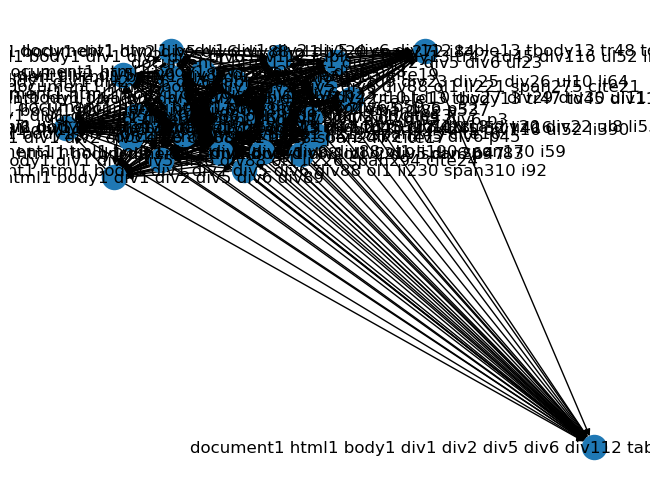

In [559]:
G = nx.DiGraph()

for idx, path in enumerate(block_path):
    G.add_node(" ".join(path["path"]), tag=path["path"][-1], content = path["text"], path=path["path"], embd = embd_score[idx]["embedding"])

nodes = list(G.nodes(data="embd"))
# print(nodes)
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        # nodes[i][1] = [float(x) for x in nodes[i][1]]
        # nodes[j][1] = [float(x) for x in nodes[j][1]]
        structure_rel_score = heuristic_function(nodes[i][0].split(), nodes[j][0].split())
        simi_score = similarity([nodes[i][1]], [nodes[j][1]])[0][0]
        G.add_edge(nodes[i][0], nodes[j][0], relationship="semantic", weight=simi_score * 0.5 + structure_rel_score * 0.5)



nx.draw(G, with_labels=True)

In [560]:
len(G.edges)

496

In [314]:
nodes = list(G.nodes(data="content"))
data_for_GPT = []
for u, v, data in G.edges(data=True):
    u_content = ""
    v_content = ""
    for node in nodes:
        if node[0] == u:
            u_content = node[1]
        if node[0] == v:
            v_content = node[1]

    data_for_GPT.append((u, u_content, v, v_content))


In [258]:
def edge_inference(list_of_tuple):
    message_content = []
    batch_size = len(list_of_tuple)
    for elem in list_of_tuple:
        message_content.append(
            f'{{\n"Path 1": "{elem[0]}",\n"Content 1": "{elem[1]}",\n"Path 2": "{elem[2]}",\n"Content 2": "{elem[3]}"\n}}\n'
        )
    message_content = "["+",".join(message_content)+"]"
    print(message_content)
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
            You are a highly intelligent system trained to analyze relationships between HTML tree paths and determine the likelihood that one path supports or complements the information of the other.

            Each path represents a location in a document's structure, and the relationship is influenced by their content, position, and context.

            Your task is to:
            1. Evaluate the semantic and structural relationship between multiple pairs of paths.
            2. For each pair, return a single float score between 0.0 and 10.0, where:
            - 0.0 means the paths are completely unrelated or conflicting.
            - 10.0 means the paths strongly support each other.
            3. The number of scores MUST **exactly match** the number of input pairs.
            4. Ensure your output strictly follows this format:
                ```json
                {
                    "evaluation": [
                        {"score": <float>},
                        {"score": <float>},
                        {"score": <float>}
                    ]
                }
            **Input Format**:
            A list of string like JSON object, where each object contains:
            - **Path 1**: "Path of first block content"
            - **Content 1**: "Content of first block"
            - **Path 2**: "Path of second block content"
            - **Content 2**: "Content of second block"

            **Output Format**:
            A list of dictionaries, where each dictionary contains:
            - **Score**: [float value from 0.0 to 10.0],

            **Example**:

            **Input**:
            [
                {
                    "Path 1": "document1 html1 body1 div1 div4 div7 div8",
                    "Content 1": "Annual events History Personalities Awards and honors OthersNational Basketball Associationshow National Basketball Association",
                    "Path 2": "document1 html1 body1 div1 div4 div7 div8 div48 table8 tbody8 tr104 td343 div51 ul13 li89",
                    "Content 2": "Jordan"
                },
                {
                    "Path 1": "document2 html2 body2 div3 div6 div9",
                    "Content 1": "AI and Machine Learning Research Trends",
                    "Path 2": "document2 html2 body2 div3 div6 div9 div12 p4",
                    "Content 2": "Deep Learning advances in 2023"
                },
                {
                    "Path 1": "document2 html2 body2 div2 div5 ul1 li3",
                    "Content 1": "Top 10 programming languages in 2025",
                    "Path 2": "document2 html2 body2 div2 div5 ul1 li3 span1",
                    "Content 2": "Python"
                },
                {
                    "Path 1": "document3 html3 body3 section1 article2 p5",
                    "Content 1": "Upcoming advancements in renewable energy technologies",
                    "Path 2": "document3 html3 body3 section1 article2 p7",
                    "Content 2": "Battery storage and smart grids"
                }
            ]

            **Output**:
            {
                "evaluation": [
                    {"Score": 3.776},
                    {"Score": 9.123},
                    {"Score": 9.99},
                    {"Score": 8.41}
                ]
            }

            Evaluate the relationships and provide your output in JSON with the following format.
            """,
            },
            {
                "role": "user",
                "content": f"""Here is input for {batch_size} pairs of HTML tree paths:
                **Input**: 
                {message_content}
                Provide exact {batch_size} scores coresponding to the input.
                """,
            },
        ],
        response_format={
            "type": "json_object",  # Use 'json_object' as the allowed type
            "json_object": {
                "evaluation": [
                    {"score": "float"},
                ]
            },
        },
        model="llama-3.1-8b-instant",
        # temperature=0.8,
        stream=False,
    )

    print(chat_completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

In [315]:
store_data = data_for_GPT.copy()
len(store_data)

7065

In [309]:
data_for_GPT = store_data.copy()

GPT_scoring = []
while len(data_for_GPT) > 0:
    batch_size = 20
    GPT_scoring.append(edge_inference(data_for_GPT[:batch_size]))
    data_for_GPT = data_for_GPT[batch_size:]

    time.sleep(6)

[{
"Path 1": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1",
"Content 1": "Individual awards Honors",
"Path 2": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1 tr6 td4 div10 table3 tbody3 tr7 td5 ul3",
"Content 2": "Coach of the Year Defensive Player of the Year Executive of the Year J. Walter Kennedy Citizenship Community Assist Award"
}
,{
"Path 1": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1",
"Content 1": "Individual awards Honors",
"Path 2": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1 tr6 td4 div10 table3 tbody3 tr7 td6 ul4",
"Content 2": "All-Star Game MVP"
}
,{
"Path 1": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1",
"Content 1": "Individual awards Honors",
"Path 2": "document1 html1 body1 div1 div4 div7 div8 p1 b1",
"Content 2": "National Basketball Association All-Star Game Most Valuable Player"
}
,{
"Path 1": "document1 html1 body1 div1 div4 div7 div8 table1 tbody1",
"Content 1": "Individual awards Honors",
"Path 2": "

BadRequestError: Error code: 400 - {'error': {'message': "Failed to generate JSON. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'json_validate_failed', 'failed_generation': '{\n   "evaluation": [\n       {"score": 9.992},\n       {"score": 8.01},\n       {"score": 2.81},\n       {"score": 0.098},\n       {"score": 1.099,\n       "score": 3.09, \n       {"score": 0.0},\n       {"score": 1.23},\n       {"score": 3.10},\n       {"score": 8.5},\n       {"score": 3.10},\n       {"score": 8.32,\n       "score": 1.29, \n       {"score": 0.000},\n       {"score": 0.0},\n       {"score": 1.15},\n       {"score": 3.000},\n       {"score": 9.3},\n       {"score": 5.33}\n   ]\n}'}}

In [310]:
edge_score = []

for raw_score in GPT_scoring:

    raw_score = raw_score.lower()

    process_score = json.loads(raw_score)["evaluation"]
    for score in process_score:
        edge_score.append(float(score["score"]))
    

In [273]:
import numpy as np

In [561]:
def retrieve_answer(G: nx.DiGraph, question: str, ques_embd):
    score_rank = []
    for node, data in G.nodes(data=True):
        score_rank.append(similarity([data["embd"]], [ques_embd])[0][0])
        
    top5_idx = np.argsort(score_rank)[-5:][::-1]
    top5_nodes = [list(G.nodes)[idx] for idx in top5_idx]
    print(len(top5_nodes))
    # Step 3: Traverse the graph starting from the top 5 nodes
    visited = set()
    answers = []

    def traverse(node, accumulated_weight=0):
        # Avoid revisiting nodes
        if node in visited:
            return
        visited.add(node)

        # Update node rank with accumulated weight
        score_rank[list(G.nodes).index(node)] += accumulated_weight
        print(accumulated_weight)
        # Collect answer if node is relevant
        answers.append((G.nodes[node]['content'], score_rank[list(G.nodes).index(node)]))

        # Sort outgoing edges by weight and traverse the most relevant ones
        neighbors = list(G.neighbors(node))
        neighbors.sort(key=lambda n: G[node][n]['weight'], reverse=True)
        print("neighbors: ", neighbors)
        for neighbor in neighbors[:10]:
            traverse(neighbor, accumulated_weight=G[node][neighbor]['weight'] * 0.9 + accumulated_weight * 0.1)

    # Start traversal from the top 5 nodes
    for start_node in top5_nodes:
        traverse(start_node)
    # Start traversal from the top 5 nodes
    for start_node in top5_nodes:
        print(start_node)
        traverse(start_node)


    # Step 4: Aggregate answers and return the best one
    if answers:
        # Sort answers by relevance score
        answers.sort(key=lambda x: x[1], reverse=True)

        return answers  # Return the text of the most relevant node
    else:
        return "No relevant answer found."
    
answer = retrieve_answer(G, ques1, ques_embd)

5
0
neighbors:  ['document1 html1 body1 div1 div2 div5 div6 p48', 'document1 html1 body1 div1 div2 div5 div6 p47', 'document1 html1 body1 div1 div2 div5 div6 p45', 'document1 html1 body1 div1 div2 div5 div6 ul23', 'document1 html1 body1 div1 div2 div5 div6 div89', 'document1 html1 body1 div1 div2 div5 div6 p59', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li190 span170 i59', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li220 span272 i84', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li194 span182 a537', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li230 span310 i92', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li226 span294 cite24', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li212 span243 cite16', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li221 span275 cite21', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li213 span247 cite17', 'document1 html1 body1 div1 div2 div5 div6 div88 ol1 li209 span231 cite13', 'document1 ht

In [562]:
print(answer)

[('Photon entanglement', 16.278771985103802), ('Quantum noise', 15.468702398446446), ("Schrödinger's cat", 10.432233596559477), ('Schrödinger', 10.422525217125573), ('Unpredictable Tunneling of a Classical Wave–Particle Association', 9.950020854826812), ('Single-Particle Diffraction and Interference at a Macroscopic Scale', 9.937694875487344), ('Observation of Collisional Decoherence in Interferometry', 9.910665060397232), ('Matter-wave interferometer for large molecules', 9.872085749384645), ('Path-memory induced quantization of classical orbits', 9.850095520290164), ('Quantum interference of large organic molecules', 9.84491185615671), ("Afshar's Experiment Does Not Show a Violation of Complementarity", 9.818308461425511), ('Single molecules in a quantum interference movie', 9.793131499806352), ('Wave–particle duality', 9.64461152689536), ('Thomas Young: The Double Slit Experiment', 9.607805408972219), ('Wave–Particle Duality: Light', 9.47092279259342), ('Louis-Victor de Broglie de B

In [563]:
retrieve_ans = ""
for ans in answer:
    retrieve_ans += ans[0] + " / "

In [565]:
def retrieve_(additional_content, question):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
            You are a helpful assistant responsible for summarizing information and using knowledge to answering question.
            Given a string of many informations, and a question, all related to that question.
            Please answer the question using your knowledge with the support of information provided.
            If the provided informations are contradictory, please resolve the informations and answer the question base on your knowledge.
            
            ### INPUT ###
            "Additional Information": Information.
            "Question": Question.
            
            ### OUTPUT ###
            "Answer": Answer of the given question use your knowledge with additional information.
            """,
            },
            {
                "role": "user",
                "content": f"""
                Additional Information: {additional_content}
                Question: {question}
                Please provide the answer in JSON format {{"answer": Your Answer}}
                """,
            },
            
        ],
        response_format={
            "type": "json_object",  # Use 'json_object' as the allowed type
            "json_object": {
                "answer": [
                    {"answer": "string"},
                ]
            },
        },
        model="llama-3.1-8b-instant",
        temperature=0.8,
        stream=False,
    )

    print(chat_completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

In [566]:
final_answer = json.loads(retrieve_(retrieve_ans, ques1))["answer"]

{
   "answer": "Louis de Broglie proposed the idea that particles can exhibit wave-like behavior, and Max Planck, Albert Einstein, Arthur Compton, and Niels Bohr also contributed to the understanding of wave-particle duality."
}


In [339]:
final_answer

'Kareem Abdul-Jabbar with 6 All-Star Game MVP awards, however the information provided was missing so I have looked at the Wikipedia. Although Wikipedia article mentioned the NBA-all star mvp, the full list is not present'

In [295]:
short_answer

{'id': ['16561957862311810757',
  '9013765907572342552',
  '17009528298897439994',
  '1543919103567142329',
  '12851569555955771450'],
 'long_answer': [{'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 449,
   'end_token': 759,
   'start_byte': 64455,
   'end_byte': 68310,
   'candidate_index': 40},
  {'start_token': 3326,
   'end_token': 3606,
   'start_byte': 156131,
   'end_byte': 160678,
   'candidate_index': 121}],
 'short_answers': [{'start_token': [450, 453],
   'end_token': [452, 455],
   'start_byte': [64504, 64571],
   'end_byte': [64514, 64582],
   'text': ['Bob Pettit', 'Kobe Bryant']},
  {'start_token': [450, 453],
   'end_token': [452, 455],
   'start_byte': [6

###For Testing:

  1. Wave–particle duality

  Q: What is wave–particle duality?
  A: Wave–particle duality is a fundamental concept in quantum mechanics, which states that particles, such as electrons, can exhibit both wave-like and particle-like behavior depending on how they are observed.

  Q: Which experiment demonstrates the wave nature of particles?
  A: The Young's Double Slit Experiment and the Afshar experiment, as well as decoherence of matter waves by thermal emission of radiation, real-time single-molecule imaging of quantum interference, and the Talbot Lau interferometer demonstrate the wave nature of particles..

  Q: Who proposed the idea that particles can exhibit wave-like behavior?
  A: Louis de Broglie proposed the idea that particles can exhibit wave-like behavior, and Max Planck, Albert Einstein, Arthur Compton, and Niels Bohr also contributed to the understanding of wave-particle duality..

  2. List of current United States senators

  Q: How many U.S. senators are there in total?
  A: There are 100 senators in the US Senate, with 47 Democrats and 53 Republicans. The remaining 3 are Independents.

  Q: What is the term length for a U.S. senator?
  A: The term length for a U.S. senator is 6 years.

  3. Deposition (phase transition)

  Q: What is deposition in terms of phase transition?
  A: Deposition is the phase transition in which a gas transforms directly into a solid without passing through the liquid phase.

  Q: What is an example of deposition occurring in nature?
  A: Frost formation on surfaces is an example of deposition, where water vapor turns directly into ice.

  Q: What is the reverse process of deposition called?
  A: The reverse process of deposition is called sublimation.

  4. Longest word in English

  Q: What is the longest word in a major English dictionary?
  A: "Pneumonoultramicroscopicsilicovolcanoconiosis" is the longest word in a major English dictionary.

  Q: What does "antidisestablishmentarianism" mean?
  A: "Antidisestablishmentarianism" refers to opposition to the disestablishment of the Church of England.

  Q: Which word is known for being coined to have many letters but is not technical?
  A: "Supercalifragilisticexpialidocious" is a coined word known for its length and was popularized by the film "Mary Poppins."

  5. NBA All-Star Game Kobe Bryant Most Valuable Player

  Q: What is the NBA All-Star Game Kobe Bryant Most Valuable Player award?
  A: It is an annual award given to the most outstanding player of the NBA All-Star Game, renamed in honor of Kobe Bryant in 2020.

  Q: Who holds the record for the most NBA All-Star MVP awards?
  A: Kobe Bryant and LeBronJames are tied, each having won the award 4 times, following up is Michael Jordan with 3.

  Q: When was the NBA All-Star MVP award first introduced?
  A: The NBA All-Star MVP award was first introduced in 1953.

  6. Water distribution on Earth

  Q: What percentage of Earth's water is freshwater?
  A: Approximately 2.5% of Earth's water is freshwater.

  Q: Where is the majority of Earth's freshwater stored?
  A: The majority of Earth's freshwater is stored in glaciers and ice caps.

  Q: What fraction of Earth's freshwater is accessible for human use?
  A: Only about 1% of Earth's freshwater is easily accessible for human use, found in lakes, rivers, and shallow groundwater.

  7. Who Wants to Be a Millionaire? New Zealand

  Q: Who hosted the New Zealand version of "Who Wants to Be a Millionaire?"
  A: Mike Hosking hosted the New Zealand version of the show.

  Q: In what year did "Who Wants to Be a Millionaire? New Zealand" first air?
  A: It first aired in 2008.

  Q: Where was the New Zealand version of the show filmed?
  A: It was filmed in Melbourne, Australia, on the set of the Australian version.

  8. Brock

  Q: In the Pokémon series, who is Brock?
  A: Brock is a character who is the Pewter City Gym Leader and a companion of Ash Ketchum.

  Q: What is Brock University?
  A: Brock University is a public university located in St. Catharines, Ontario, Canada.

  Q: Who is Eddie Brock in Marvel Comics?
  A: Eddie Brock is a character who becomes the host for the alien symbiote known as Venom.

  9. pH

  Q: What does pH measure?
  A: pH measures the acidity or alkalinity of a solution.

  Q: What is the pH value of pure water at 25°C?
  A: The pH value of pure water at 25°C is approximately 7, which is neutral.

  Q: Who introduced the concept of pH?
  A: The concept of pH was introduced by Danish chemist Søren Peder Lauritz Sørensen in 1909.

  10. Edible bird's nest

  Q: What is an edible bird's nest made from?
  A: An edible bird's nest is made from the solidified saliva of swiftlets.

  Q: In which cuisine are edible bird's nests considered a delicacy?
  A: They are considered a delicacy in Chinese cuisine.

  Q: What is the primary dish prepared using edible bird's nests?
  A: The primary dish is bird's nest soup.